# Bayesian Neural Network (VI) for classification (under Development)

In [1]:
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

/Users/zhenwend/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generate Synthetic Data

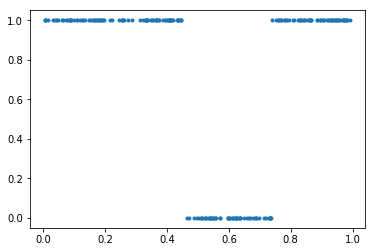

In [75]:
import GPy
%matplotlib inline
from pylab import *

np.random.seed(4)
k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(200,1)
y = np.random.multivariate_normal(mean=np.zeros((200,)), cov=k.K(x), size=(1,)).T>0.
plot(x[:,0], y[:,0], '.')

In [76]:
D = 10
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=1))
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=D))
    net.add(nn.Dense(2, flatten=False, in_units=D))
net.initialize(mx.init.Xavier(magnitude=1))

In [77]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling

In [78]:
m = mf.components.Model()
m.N = mf.components.Variable()
m.f = mf.components.functions.MXFusionGluonFunction(net, nOutputs=1, broadcastable=False)
m.x = mf.components.Variable(shape=(m.N,1))
m.r = m.f(m.x)
for _,v in m.r.factor.block_variables:
    v.set_prior(mf.components.distributions.Normal(mean=mx.nd.array([0]),variance=mx.nd.array([3.])))
m.y = mf.components.distributions.Categorical.define_variable(log_prob=m.r,  shape=(m.N,1))
m.show()

Variable(45b58) ~ Normal(mean=Variable(738a7), variance=Variable(9ef9b))
Variable(d7aa2) ~ Normal(mean=Variable(b4564), variance=Variable(02ad0))
Variable(ace48) ~ Normal(mean=Variable(3989f), variance=Variable(49e6a))
Variable(35ae3) ~ Normal(mean=Variable(666b4), variance=Variable(5c0d8))
Variable(7a303) ~ Normal(mean=Variable(9d461), variance=Variable(dd20b))
Variable(28ccc) ~ Normal(mean=Variable(37c47), variance=Variable(a7de6))
r = GluonFunctionEvaluation(nn_dense0_weight=Variable(28ccc), nn_dense0_bias=Variable(7a303), nn_dense1_weight=Variable(35ae3), nn_dense1_bias=Variable(ace48), nn_dense2_weight=Variable(d7aa2), nn_dense2_bias=Variable(45b58), nn_input_0=x)
y ~ Categorical(log_prob=r)


In [79]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference, MAP

In [80]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=5, model=m, posterior=q, observed=observed)
# alg = MAP(model=m, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [81]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference_parameters.py:52: UserWarning:InferenceParameters has already been initialized.  The existing one will be overwritten.


In [82]:
for v_name, v in m.r.factor.block_variables:
    uuid = v.uuid
    loc_uuid = infr.inference_algorithm.posterior[uuid].factor.variance.uuid
    a = infr.params.param_dict[loc_uuid].data().asnumpy()
    a[:] = 1e-8
    infr.params[infr.inference_algorithm.posterior[uuid].factor.mean] = net.collect_params()[v_name].data()
    infr.params[infr.inference_algorithm.posterior[uuid].factor.variance] = mx.nd.array(a)

In [83]:
infr.run(max_iter=500, learning_rate=1e-1, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference.py:111: UserWarning:Trying to initialize the inference twice, skipping.


Iteration 1 logL: -1544.5255126953125
Iteration 2 logL: -1539.4837646484375
Iteration 3 logL: -1511.021484375
Iteration 4 logL: -1505.3983154296875
Iteration 5 logL: -1494.5648193359375
Iteration 6 logL: -1491.2451171875
Iteration 7 logL: -1478.662841796875
Iteration 8 logL: -1478.6864013671875
Iteration 9 logL: -1471.1865234375
Iteration 10 logL: -1452.61962890625
Iteration 11 logL: -1451.615478515625
Iteration 12 logL: -1444.682373046875
Iteration 13 logL: -1445.5955810546875
Iteration 14 logL: -1430.4305419921875
Iteration 15 logL: -1418.5712890625
Iteration 16 logL: -1418.8111572265625
Iteration 17 logL: -1404.1358642578125
Iteration 18 logL: -1400.627685546875
Iteration 19 logL: -1381.745361328125
Iteration 20 logL: -1376.2139892578125
Iteration 21 logL: -1372.777099609375
Iteration 22 logL: -1366.9664306640625
Iteration 23 logL: -1361.6920166015625
Iteration 24 logL: -1342.0687255859375
Iteration 25 logL: -1341.3878173828125
Iteration 26 logL: -1335.53271484375
Iteration 27 logL:

Iteration 219 logL: -216.9544677734375
Iteration 220 logL: -171.2532196044922
Iteration 221 logL: -174.9771270751953
Iteration 222 logL: -206.28012084960938
Iteration 223 logL: -191.87185668945312
Iteration 224 logL: -153.0070037841797
Iteration 225 logL: -181.36277770996094
Iteration 226 logL: -169.47288513183594
Iteration 227 logL: -156.15509033203125
Iteration 228 logL: -179.83694458007812
Iteration 229 logL: -183.0515594482422
Iteration 230 logL: -163.0454864501953
Iteration 231 logL: -184.2140350341797
Iteration 232 logL: -219.8138885498047
Iteration 233 logL: -162.65086364746094
Iteration 234 logL: -144.58377075195312
Iteration 235 logL: -179.9770965576172
Iteration 236 logL: -183.8132781982422
Iteration 237 logL: -199.29489135742188
Iteration 238 logL: -151.03273010253906
Iteration 239 logL: -160.94741821289062
Iteration 240 logL: -176.21104431152344
Iteration 241 logL: -188.37820434570312
Iteration 242 logL: -196.54141235351562
Iteration 243 logL: -162.23831176757812
Iteration 

Iteration 431 logL: -134.34768676757812
Iteration 432 logL: -134.56263732910156
Iteration 433 logL: -180.6781463623047
Iteration 434 logL: -158.80487060546875
Iteration 435 logL: -159.59298706054688
Iteration 436 logL: -139.64794921875
Iteration 437 logL: -133.45777893066406
Iteration 438 logL: -152.6923370361328
Iteration 439 logL: -156.44227600097656
Iteration 440 logL: -157.8925018310547
Iteration 441 logL: -167.68077087402344
Iteration 442 logL: -161.24176025390625
Iteration 443 logL: -159.16549682617188
Iteration 444 logL: -172.21835327148438
Iteration 445 logL: -156.8822479248047
Iteration 446 logL: -133.2530975341797
Iteration 447 logL: -153.4013214111328
Iteration 448 logL: -133.96762084960938
Iteration 449 logL: -138.84234619140625
Iteration 450 logL: -183.0357666015625
Iteration 451 logL: -170.00534057617188
Iteration 452 logL: -157.46279907226562
Iteration 453 logL: -155.4312286376953
Iteration 454 logL: -178.26963806152344
Iteration 455 logL: -136.466552734375
Iteration 456

In [12]:
for uuid, v in infr.inference_algorithm.posterior.variables.items():
    if uuid in infr.params.param_dict:
        print(v.name, infr.params[v])

In [84]:
xt = np.linspace(0,1,100)[:,None]

In [85]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/core/factor_graph.py:65: UserWarning:The value N has already been assigned in the model.
 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/core/factor_graph.py:65: UserWarning:The value y has already been assigned in the model.
 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference_parameters.py:52: UserWarning:InferenceParameters has already been initialized.  The existing one will be overwritten.


In [86]:
yt = res[m.r].asnumpy()

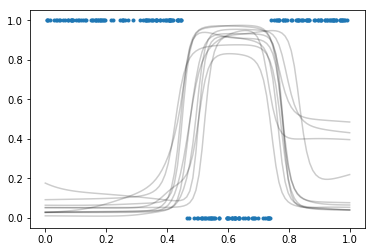

In [87]:
# plot(xt[:,0],yt[:,0])
yt_mean = yt.mean(0)
yt_std = yt.std(0)
#plot(xt[:,0], yt.mean(0)[:,0])
#errorbar(xt[:,0],y=yt_mean[:,0],yerr=yt_std[:,0]*2)
for i in range(yt.shape[0]):
    plot(xt[:,0],1./(1+np.exp(-yt[i,:,0])),'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')